In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt

from simulation import cancer
from generate import simulate_blackwell_glynn
from nsmm import nsmm_lag1, nsmm_lag1_cate
from msm import MarginalStructuralModel

In [2]:
df = simulate_blackwell_glynn(n_units=1000, t_periods=20)
nsmm_lag1(df, unit = 'i' , treatment = 'X',outcome = 'Y',common_causes= ['Z'])

(-0.0913801121686876, -0.10421430900215296)

In [2]:
df = simulate_blackwell_glynn(n_units=1000, t_periods=20)
msm = MarginalStructuralModel(
    treatment=['X'],
    outcome='Y',
    common_causes=['Z'],
    id_col='i', time_col='t'
)
msm.fit(df)
msm.summary()

Model coefficients:
                   X: -0.090
              X_lag1: -0.080
                   Z:  0.019
              Y_lag1:  0.041
              Z_lag1:  0.010
           Intercept:  0.749


# Cancer data

In [2]:

np.random.seed(100)

num_time_steps = 60  # 6 month followup
num_patients = 1000

simulation_params = cancer.get_confounding_params(num_patients, chemo_coeff=10.0, radio_coeff=10.0)
simulation_params['window_size'] = 15

outputs = cancer.simulate(simulation_params, num_time_steps)

e:\projects\learning_causal_inference\time_series\simulation\cancer.py:357: RuntimeWarning: overflow encountered in exp
  if recovery_rvs[i, t] < np.exp(-cancer_volume[i, t] * tumour_cell_density):


## Real effect

In [3]:
msm = MarginalStructuralModel(
    treatment=['chemo_instant_dosage', 'radio_dosage'],
    outcome='cancer_volume',
    common_causes=[],
    id_col='Patient_ID', time_col='Time_Point'
)
msm.fit(outputs)
msm.summary()

Model coefficients:
chemo_instant_dosage: -0.115
        radio_dosage: -0.368
chemo_instant_dosage_lag1: -10.896
   radio_dosage_lag1: -76.660
  cancer_volume_lag1:  0.977
chemo_instant_dosage_x_chemo_instant_dosage_lag1: -2.525
chemo_instant_dosage_x_radio_dosage_lag1:  3.919
chemo_instant_dosage_x_cancer_volume_lag1:  0.003
radio_dosage_x_chemo_instant_dosage_lag1: -1.730
radio_dosage_x_radio_dosage_lag1:  12.770
radio_dosage_x_cancer_volume_lag1:  0.008
           Intercept:  7.984


In [4]:
# Assuming df is your dataframe
def prepare_data_for_outcome(df, drug_half_life = 1):
    df = df.copy()
    df['chemo_dosage'] = 0.0
    df['previous_cancer_volume'] = df['cancer_volume']
    for pid, group in df.groupby('Patient_ID'):
        group = group.sort_values('Time_Point')
        chemo_instant_dosage = group['chemo_instant_dosage']
        previous_chemo_dose = group['chemo_instant_dosage'].shift(1)
        previous_cancer_volume = group['cancer_volume'].shift(1)
        chemo_dosages = cancer.get_chemo_dosage(chemo_instant_dosage, previous_chemo_dose, drug_half_life)
        

        df.loc[group.index, 'chemo_dosage'] = chemo_dosages
        df.loc[group.index, 'previous_cancer_volume'] = previous_cancer_volume



    return df.dropna().reset_index(drop=True)

# Example usage
df = prepare_data_for_outcome(outputs)

# drop some row since it need lag data
n_time = int(len(df)/num_patients)

-40.57068991966945

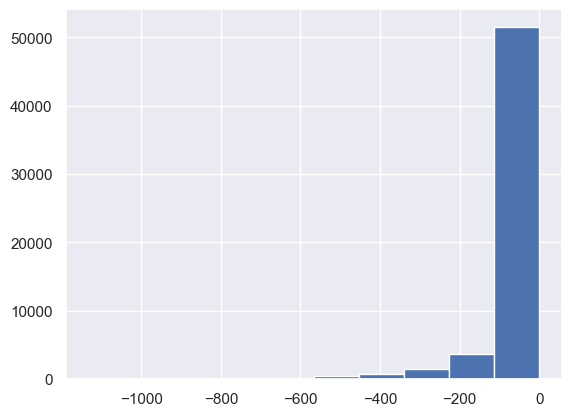

In [10]:
not_treat = cancer.get_cancer_outcome(
    df['previous_cancer_volume'], 
    df['chemo_dosage'], np.array([0]* len(df['radio_dosage'])), 
    simulation_params['rho'].repeat(n_time), simulation_params['K'].repeat(n_time), 
    simulation_params['beta_c'].repeat(n_time), simulation_params['alpha'].repeat(n_time), 
    simulation_params['beta'].repeat(n_time))

treat = cancer.get_cancer_outcome(
    df['previous_cancer_volume'], 
    df['chemo_dosage'],np.array([2]* len(df['radio_dosage'])), 
    simulation_params['rho'].repeat(n_time), simulation_params['K'].repeat(n_time), 
    simulation_params['beta_c'].repeat(n_time), simulation_params['alpha'].repeat(n_time), 
    simulation_params['beta'].repeat(n_time))

plt.hist(treat-not_treat)
(treat-not_treat).mean()

In [13]:
outputs_intervention = msm._prepare_data(outputs, drop = False)
outputs_intervention['radio_dosage'] = 2

outputs_baseline = deepcopy(outputs_intervention)
outputs_baseline['radio_dosage'] = 0

baseline = msm.predict(outputs_baseline, prepare_data=True)
intervention = msm.predict(outputs_intervention, prepare_data=False)


np.nanmean(intervention) - np.nanmean(baseline)

-3.0122345615523614

In [27]:
outputs_intervention['cancer_volume'][outputs_intervention['cancer_volume']<0]

Series([], Name: cancer_volume, dtype: float64)